In [4]:
percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/dopplero.mat"
struttura = scipy.io.loadmat(percorsoIn)['infos']


freqCorrOrig = struttura['freqniu'][0,0][0]
velPerPosOrig = struttura['velperpos'][0,0][0]
print(freqCorrOrig, velPerPosOrig)


[ 107.97597025  107.97853354  107.97999828 ...,  109.02457878  109.02494501
  109.02726447] [  7.12521614e-05   7.10559032e-05   7.09053964e-05 ...,  -5.39490072e-05
  -5.41624015e-05  -5.43676755e-05]


# Input dati

In [1]:
import tensorflow as tf
import numpy
import scipy.io
import time

#nb le fft da 8192 sono intervallo freq da x Hz a y Hz
#          da 4096 sono intervallo freq da x Hz a y Hz
percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI52.mat"
#percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadrato4096Quad.mat"
quadrato = scipy.io.loadmat(percorsoIn)['quad']
#print(quadrato)
#carico file dati
percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi52HWI.mat"
#percorsoDati = "/home/protoss/Documenti/TESI/DATI/datiunmese.mat"

struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
tempi = struttura['peaks'][0,0][0]
frequenze = struttura['peaks'][0,0][1]
pesi = (struttura['peaks'][0,0][4]+1)
#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000 #WARNING DA DEFINIRE MEGLIO SECURBELT

tFft = 8192
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato
#print(nstepsFreq)

#tempi
#da definire epoca come mediana di tempi di tutto il run
epoca = struttura['basic_info'][0,0]['run'][0,0]['epoch'][0,0][0,0]

#per doppler corr


veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:]
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]
#print(indices.shape, veloc.shape, nTempi)


In [105]:
nTempi = (numpy.amax(tempi)-numpy.amin(tempi))*3600*24/4096
nFrequenze = (numpy.amax(frequenze)-numpy.amin(frequenze))/stepFreq
print(nTempi, nFrequenze)

5635.99975586 8548.0


## Qui uso gli index

In [76]:
#"vanilla"

quadratoNP = quadrato[0]

start = time.time()
#nPunti = quadrato.shape[0]
velocitas = numpy.zeros((3,indices[nTempi]-1))
print(velocitas.shape)
for i in numpy.arange(0,nTempi-1):
    intervallo = numpy.arange(indices[i]-1,indices[i+1]-1)
    for j in intervallo:
        velocitas[:,j] = veloc[:,i]

velPerPosIndex = numpy.dot(quadratoNP,velocitas)
#print(velPerPos)
frequenzeIndex = frequenze / (1+velPerPosIndex)     
    
time.time()-start



#for punto in numpy.arange(nPunti):
#    velPerPos = numpy.dot(quadrato[punto],velocitas)
#    frequenzeIndex = frequenze / (1+velPerPos)


(3, 1705679)


1.3770029544830322

In [9]:
#un for tolto

quadratoNP = quadrato[0]

start = time.time()
#nPunti = quadrato.shape[0]
velocitas = numpy.zeros((3,frequenze.size))
for i in numpy.arange(0,nTempi-1):
    inizio = indices[i]-1
    fine = indices[i+1]-1
    velocitas[:,inizio:fine] = veloc[:,i:i+1]

velPerPosIndex = numpy.dot(quadratoNP,velocitas)
divisoreIndex = 1+velPerPosIndex
#print(velPerPos)
frequenzeUnfor = frequenze / divisoreIndex
    
time.time()-start



#for punto in numpy.arange(nPunti):
#    velPerPos = numpy.dot(quadrato[punto],velocitas)
#    frequenzeIndex = frequenze / (1+velPerPos)



0.09705281257629395

In [116]:
#un for tolto

quadratoNP = quadrato[0]
indicesOpt = indices-1
inizi = indicesOpt[:-1]
fini = indicesOpt[1:]

def primaFor():
    velocitas = numpy.zeros((3,frequenze.size))
    for i in numpy.arange(0,nTempi-1):
        velocitas[:,inizi[i]:fini[i]+1] = veloc[:,i:i+1]
    velPerPosIndex = numpy.dot(quadratoNP,velocitas)
    divisoreIndex = 1+velPerPosIndex
    freq = frequenze / divisoreIndex
    return freq

def primaProd():
    velPerPosIndex = numpy.dot(quadratoNP,veloc)
    velocitas = numpy.zeros(frequenze.size)
    for i in numpy.arange(0,nTempi-1):
        velocitas[inizi[i]:fini[i]+1] = velPerPosIndex[i:i+1]
    divisoreIndex = 1+velocitas
    freq = frequenze / divisoreIndex
    return freq

%time freqPrimaFor = primaFor()
%time freqPrimaProd = primaProd()

#for punto in numpy.arange(nPunti):
#    velPerPos = numpy.dot(quadrato[punto],velocitas)
#    frequenzeIndex = frequenze / (1+velPerPos)


CPU times: user 104 ms, sys: 84 ms, total: 188 ms
Wall time: 57.2 ms
CPU times: user 100 ms, sys: 296 ms, total: 396 ms
Wall time: 61.1 ms


In [92]:
print(frequenze.size)
quadratoNP = quadrato[0]

starts = indicesOpt[:-1]
ultimiStarts = numpy.where(starts ==frequenze.size)[0]
starts = starts[1:ultimiStarts[0]]
ends = indicesOpt[1:]
ultimiEnds = numpy.where(ends ==frequenze.size)[0]
ends = ends[1:ultimiEnds[0]+1]-1

velPerPosIndex = numpy.dot(quadratoNP,veloc)


def slices2arr_gather(ar, starts, ends, N):
    id_arr = numpy.zeros((N),dtype=int)
    id_arr[starts[1:]] = 1
    c = id_arr.cumsum()
    
    id_arr[ends[1:]] =id_arr[ends[1:]]-1
    out = numpy.where(id_arr.cumsum()==0, 0, ar[c])
    
    
    out[starts[0]:ends[0]] = ar[0]
    out[ends] = out[ends-1]
    return out 

%time velocitas = slices2arr_gather(velPerPosIndex, starts, ends, frequenze.size)



divisoreIndex = 1+velocitas

frequenzeVect = frequenze / divisoreIndex

1705679
[      0     449    1070 ..., 1703903 1704498 1705102] [    448    1069    1250 ..., 1704497 1705101 1705678]
CPU times: user 52 ms, sys: 172 ms, total: 224 ms
Wall time: 37.1 ms


In [16]:
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)
times = numpy.nonzero(matrix)[0]+1
positions = numpy.nonzero(matrix)[1]

indexes = numpy.where(numpy.diff(times)>0)[0]+1
indexes = numpy.concatenate(([0],indexes, [times.size]))
nTimes = numpy.size(indexes)-1
speeds = numpy.random.rand(nTimes)




def slices2arr_for():
    expandedSpeeds = numpy.zeros(positions.size)
    for i in numpy.arange(0,nTimes):
        expandedSpeeds[starts[i]:ends[i]] = speeds[i]
    return expandedSpeeds

def slices2arr_gather(ar, starts, ends, N):
    id_arr = numpy.zeros((N),dtype=numpy.int64)
    id_arr[starts[1:]] = 1
    c = id_arr.cumsum()
    
    %time id_arr[ends[1:]] =id_arr[ends[1:]]-1
    
    out = numpy.where(id_arr.cumsum()==0, 0, ar[c])
    
    out[starts[0]:ends[0]] = ar[0]
    out[ends] = out[ends-1]
    return out 

def slices2arr_addat(ar, starts, ends, N):
    id_arr = numpy.zeros((N),dtype=numpy.int64)
    id_arr[starts[1:]] = 1
    c = id_arr.cumsum()

    %time numpy.add.at(id_arr, ends[1:],-1)
    out = numpy.where(id_arr.cumsum()==0, 0, ar[c])
    out[starts[0]:ends[0]] = ar[0]
    out[ends] = out[ends-1]
    return out 

starts = indexes[:-1]
ends = indexes[1:]

%time a= slices2arr_for()

starts = indexes[:-1]
ends = indexes[1:]-1

%time b= slices2arr_gather(speeds, starts, ends, positions.size)
%time c=slices2arr_addat(speeds, starts, ends, positions.size)







CPU times: user 24 ms, sys: 76 ms, total: 100 ms
Wall time: 96.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 325 µs
CPU times: user 416 ms, sys: 412 ms, total: 828 ms
Wall time: 824 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.21 ms
CPU times: user 484 ms, sys: 376 ms, total: 860 ms
Wall time: 857 ms


In [19]:
print(numpy.nonzero(a-b))

(array([], dtype=int64),)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 110 µs


array([ 0.68957219,  0.68957219,  0.68957219,  0.68957219,  0.68957219,
        0.68957219,  0.08806818,  0.08806818,  0.30800006,  0.30800006,
        0.30800006,  0.30800006,  0.30800006,  0.30800006,  0.33137941,
        0.33137941,  0.33137941,  0.33137941,  0.33137941,  0.33137941,
        0.3426748 ,  0.3426748 ,  0.3426748 ,  0.3426748 ,  0.28545053,
        0.28545053,  0.28545053,  0.28545053,  0.28545053,  0.28545053,
        0.28545053,  0.74089079,  0.74089079,  0.74089079,  0.74089079,
        0.83084563,  0.83084563,  0.83084563,  0.87286238,  0.87286238,
        0.87286238,  0.87286238,  0.88390333,  0.88390333,  0.88390333,
        0.88390333,  0.88390333,  0.88390333,  0.        ])

# Tensorflow

In [6]:
sessione = tf.Session()

tempiTF = tf.constant(tempi, dtype=tf.float64)
velTF = tf.constant(veloc, dtype=tf.float64)
freqTF = tf.constant(frequenze, dtype=tf.float64)
quadTF = tf.constant(quadrato, dtype=tf.float64)

#tempiTF = tempiTF -tf.reduce_min(tempiTF)
tempiTF = tempiTF - primoTempo
tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiTF)
indiciUniciRipetutiTF = sessione.run(indiciUniciRipetuti)

indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]
nIndici = tf.size(tempiUnici)

differenze = tempiUnici[1:]-tempiUnici[:-1]
stepTempi = tf.reduce_min(differenze)

# il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
# vedo dove sono i salti
stepSaltati = differenze/stepTempi
stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

# ora seleziono solo gli indici dell'array di velocità
# ai quali il relativo step temporale ha frequenze non nulle nella peakmap

indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
indiciVel = indiciVel + tf.cumsum(stepSaltati)
indiciVel = tf.concat([[tempiPrima], indiciVel],0)

# qui va messa parte per calcolare i pesi, che per ora non mettiamo
#def doppcorr(i):
    #qui faccio la doppl corr
velPerPos = tf.matmul(tf.reshape(quadTF[0], [1,3]),velTF)
velPerPos = velPerPos
velPerPos = velPerPos[0]
velPerPosTF = sessione.run(velPerPos)
#nel programma originale c'è un prodotto elementwise infattibile
#(tra due array di diversa dimensione)
# c'è anche un for che considera buchi di tempi dentro e prima

#qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
#c'è una differenza maggiore (un multiplo) dello step minimo
# e quindi definisco un nuovo array di velocità con i soli i valori
# che mi interessano
#velUtili = velPerPos[indiciVel]


##WARNING GATHER SBALLA IL VALORE DI POCHISSIMO MA ABBASTANZA PER ROVINARE CORR DOPPLER
velUtili = tf.gather(velPerPos, indiciVel)
velUtiliTF = sessione.run(velUtili)

divisore = tf.gather_nd(velUtili,indiciUniciRipetuti[:,None])
divisoreTF = sessione.run(divisore)
freqCorr = tf.divide(freqTF,(divisore +1))

%time freqCorrTF = sessione.run(freqCorr)

CPU times: user 376 ms, sys: 124 ms, total: 500 ms
Wall time: 257 ms


In [31]:


print(veloc.shape)
print(numpy.unique(tempi).size)
tempiTot = numpy.arange(primoTempo, numpy.amax(tempi),stepTempi)
print(tempiTot.size)

(3, 5652)
3187
1
0


(array([   0,    1,    2, ..., 3183, 3184, 3185]),)

# Numpy

In [126]:

print(veloc.shape)
print(numpy.arange(primoTempo*24*3600, numpy.amax(tempi)*24*3600, 4096).size)
print(numpy.arange(numpy.amin(tempi)*24*3600, numpy.amax(tempi)*24*3600, 4096).size)

(3, 5652)
5652
5636


In [118]:
start = time.time()
tempiDC = numpy.round(((tempi-numpy.amin(tempi))*3600*24)/4096).astype(numpy.int64)
#tempiDC = ((tempi-primoTempo)*3600*24)#.astype(numpy.int64)
tempiUnici,indiciUnici,indiciOrig = numpy.unique(tempiDC, return_index=True,return_inverse=True)
print(tempiUnici)
# qui va messa parte per calcolare i pesi che per ora non mettiamo

#qui faccio la doppl corr


nIndici = numpy.size(tempiUnici)

#differenze = numpy.round(numpy.diff(tempiUnici)).astype(numpy.int64)
differenze = numpy.diff(tempiUnici)
stepTempi = numpy.amin(differenze)


# il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
#tempiPrima =(numpy.amin(tempiUnici)/stepTempi).astype(numpy.int64)

# vedo dove sono i salti
stepSaltati = numpy.round(differenze/stepTempi).astype(numpy.int64)
#stepSaltati = differenze/stepTempi
#print(stepSaltati)

#stepSaltati = numpy.concatenate(([tempiPrima],stepSaltati))
#stepSaltati = numpy.concatenate(([0],stepSaltati))


indiciVel = numpy.zeros(numpy.size(tempiUnici))+1 #+tempiPrima
indiciVel[1:] = indiciVel[1:]+numpy.cumsum(stepSaltati)
indiciVel = numpy.round(indiciVel).astype(numpy.int64)
# e quindi definisco un nuovo array di velocità con i soli i valori
# che mi interessano


velPerPos = numpy.dot(quadrato,veloc)
velPerPos = velPerPos
velPerPos = velPerPos[0]


velUtili = velPerPos[indiciVel]
#velUtili = numpy.take(velPerPos, indiciVel)

# infine faccio la divisione

divisore = velUtili[indiciOrig]+1
#divisore = numpy.take(velUtili, indiciOrig)+1

freqCorrNP = frequenze/divisore

stop = time.time()
print(stop-start)


from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.scatter(numpy.arange(freqPrimaFor.size),freqPrimaFor-freqCorrNP, s =10)

[   0    1    2 ..., 5634 5635 5636]
0.15561485290527344


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


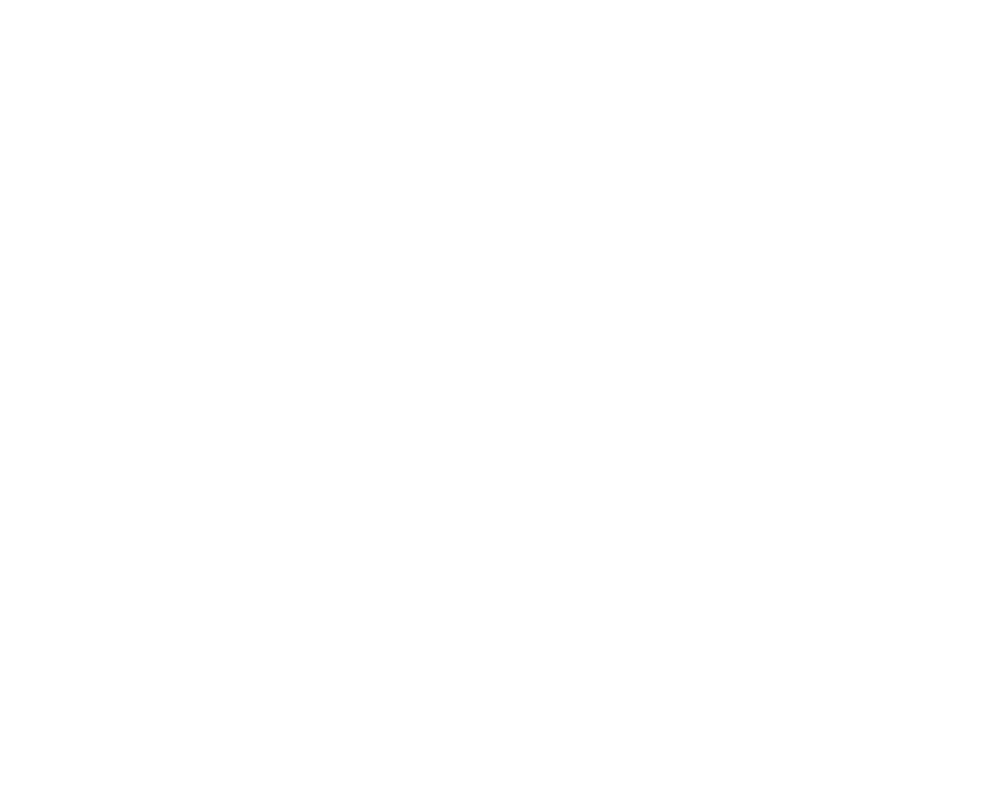

ValueError: operands could not be broadcast together with shapes (1705679,) (5652,) 

In [94]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.scatter(numpy.arange(velPerPos.size),velPerPosIndex-velPerPos, s = 10)

In [22]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.scatter(numpy.arange(tempi.size),tempi, s = 10)

<IPython.core.display.Javascript object>

# Prove

In [93]:
    import numpy

    times = numpy.array([0.1,  0.1, 0.2, 0.2])
    positNP = numpy.array([58.98962402,  58.9921875, 60.00390625, 60.00878906])

    vel = numpy.array([0.99705114,0.99974157])

    uniqueTimes = numpy.unique(times, return_index=True)
    uniqueIndices = uniqueTimes[1]
    uniqueTimes = uniqueTimes[0]

    numIndices = numpy.size(uniqueTimes)-1
    iterator = numpy.arange(numIndices)+1
    for i in iterator:
        positNP[uniqueIndices[i-1]:uniqueIndices[i]] = posit[uniqueIndices[i-1]:uniqueIndices[i]]*vel[i-1]


In [97]:
import tensorflow as tf

times = tf.constant([0.1,  0.1, 0.2, 0.2])
positTF = tf.constant([58.98962402,  58.9921875, 60.00390625, 60.00878906])

vel = tf.constant([0.99705114,0.99974157])

uniqueTimes, uniqueIndicesRepeated, counts = tf.unique_with_counts(times)
uniqueIndices = tf.cumsum(tf.pad(tf.unique_with_counts(uniqueIndicesRepeated)[2],[[1,0]]))[:-1]
out = tf.gather_nd(vel,uniqueIndicesRepeated[:,None])*positTF
sessione = tf.Session()
outpos = sessione.run(out)


In [65]:
import numpy

times = numpy.array([0.1, 0.1, 1.5, 1.9, 1.9, 1.9])
posit = numpy.array([2.1, 3.5, 0.4, 1.3, 2.7, 3.5])

vel = numpy.array([0.5,0.7,1.0])

uniqueTimes = numpy.unique(times, return_index=True)
uniqueIndices = uniqueTimes[1]
uniqueTimes = uniqueTimes[0]

numIndices = numpy.size(uniqueTimes)-1
iterator = numpy.arange(numIndices)+1
for i in iterator:
    posit[uniqueIndices[i-1]:uniqueIndices[i]] = posit[uniqueIndices[i-1]:uniqueIndices[i]]*vel[i-1]

In [98]:
print(positNP)
print(outposTF)
print(positNP-outposTF)

[ 58.81567188  58.8182278   60.00390625  60.00878906]
[ 58.81567001  58.81822586  59.98839951  59.9932785 ]
[  1.86388465e-06   1.93737304e-06   1.55067444e-02   1.55105566e-02]


In [152]:
nFrequenze = (1/stepFrequenza).astype(int)
print(nFrequenze)
tempi = tempi-primoTempo


# qui va messa parte per calcolare i pesi, che per ora non mettiamo

#qui faccio la doppl corr
velPerPos = numpy.dot(quadrato,veloc)
velPerPos = velPerPos + 1
velPerPos = velPerPos[0]

#nel programma originale c'è un prodotto elementwise infattibile
#(tra due array di diversa dimensione)
# c'è anche un for che lavora sull'array index nella struttura basicinfo
# ma array index non considera buchi di tempi dentro né prima, solo dopo
#frequenze = tf.multiply(frequenze, velPerPos)

print(numpy.size(velPerPos))

106736
8192
619


In [154]:

tempiUnici = numpy.unique(tempi, return_index=True)
indiciUnici = tempiUnici[1]
tempiUnici = tempiUnici[0]


In [155]:
nIndici = numpy.size(tempiUnici)-1
indici = numpy.arange(nIndici)+1
differenze = numpy.zeros(nIndici)
for i in indici:
    differenze[i-1] = tempiUnici[i]-tempiUnici[i-1]

stepTempi = numpy.amin(differenze)
print(stepTempi)   
print(stepTempi*nTempi)
print(numpy.amax(tempi)/stepTempi)
print(numpy.size(tempiUnici))
#print(sessione.run(frequenze))

tempiVeri = numpy.arange(nTempi)*stepTempi

tempiPrima = (numpy.amin(tempi)/stepTempi).astype(int)
tempiInmezzo = ((numpy.amax(tempi)-numpy.amin(tempi))/stepTempi).astype(int)
tempiDopo = nTempi-tempiInmezzo-tempiPrima

print(tempiPrima, tempiDopo, tempiInmezzo)

0.0474074074009
29.3451851812
484.433349676
305
15 135 469


In [151]:
stepSaltati = (differenze/stepTempi).astype(int)

indiciVel = numpy.zeros(numpy.size(tempiUnici))
indiciVel[0] = tempiPrima
indiciVel[1:numpy.size(indiciVel)] = tempiPrima+numpy.cumsum(stepSaltati)
indiciVel = indiciVel.astype(numpy.int32)
#for i in numpy.arange(numpy.size(stepSaltati)):
   # indiciVel[i] = tempiPrima+1+i
velUtili = velPerPos[indiciVel]

for i in indici:
    frequenze[indiciUnici[i-1]:indiciUnici[i]] = frequenze[indiciUnici[i-1]:indiciUnici[i]]/velUtili[i]
print(numpy.size(frequenze))

106736


In [61]:
#c'è qualche problema con le divisioni con numpy

import tensorflow as tf

times = tf.constant([0.1, 0.1, 1.5, 1.9, 1.9, 1.9])
posit = tf.constant([2.1, 3.5, 0.4, 1.3, 2.7, 3.5])

vel = tf.constant([0.5,0.7,1.0])   

uniqueTimes, uniqueIndicesRepeated, counts = tf.unique_with_counts(times)
uniqueIndices = tf.cumsum(tf.pad(tf.unique_with_counts(uniqueIndicesRepeated)[2],[[1,0]]))[:-1]
#out = tf.gather_nd(vel,uniqueIndicesRepeated[:,None])*posit
sessione = tf.Session()
#outpos = sessione.run(out)
print(sessione.run(tf.gather_nd(vel,uniqueIndicesRepeated[:,None])))

[ 0.5         0.5         0.69999999  1.          1.          1.        ]
